In [50]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [45]:
data_dir = '../datasets/Cat_Dog_data'

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform = train_transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [46]:
train_data

Dataset ImageFolder
    Number of datapoints: 22500
    Root location: ../datasets/Cat_Dog_data/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [43]:
def img_viewer(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

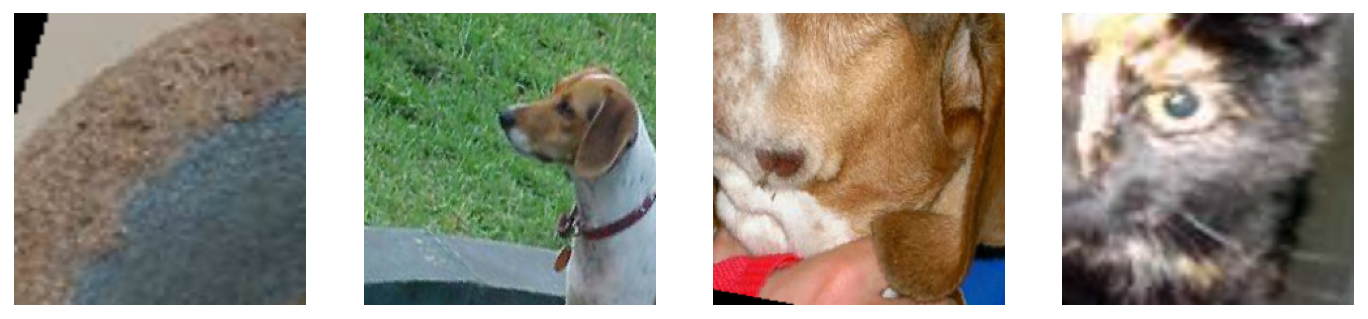

In [52]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(12,6), ncols = 4)
for ii in range(4):
    ax = axes[ii]
    img_viewer(images[ii], ax=ax, normalize=True)

In [73]:
torch.cuda.current_device()

0

In [75]:
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(pretrained=True)

# Freeze model parameters (in the features layers) to prevent backpropagation
for params in model.parameters():
    params.requires_grad = False
    
# Defining a custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024, 256)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.2)),
                                        ('fc2', nn.Linear(256,2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [76]:
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [78]:
device

device(type='cuda', index=0)

In [80]:
%%time
epochs = 5
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                
                logps = model.forward(images)
                test_loss += criterion(logps, labels)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch -> {}/{}".format(e+1, epochs),
              "Training Loss -> {:.3f}".format(running_loss/len(trainloader)),
              "Test Loss -> {:.3f}".format(test_loss/len(testloader)),
              "Accuracy -> {:.3f}".format(accuracy/len(testloader)))
            

Epoch -> 1/5 Training Loss -> 0.177 Test Loss -> 0.037 Accuracy -> 0.985
Epoch -> 2/5 Training Loss -> 0.160 Test Loss -> 0.036 Accuracy -> 0.984
Epoch -> 3/5 Training Loss -> 0.143 Test Loss -> 0.036 Accuracy -> 0.984
Epoch -> 4/5 Training Loss -> 0.143 Test Loss -> 0.033 Accuracy -> 0.984
Epoch -> 5/5 Training Loss -> 0.145 Test Loss -> 0.038 Accuracy -> 0.984
Wall time: 34min 13s


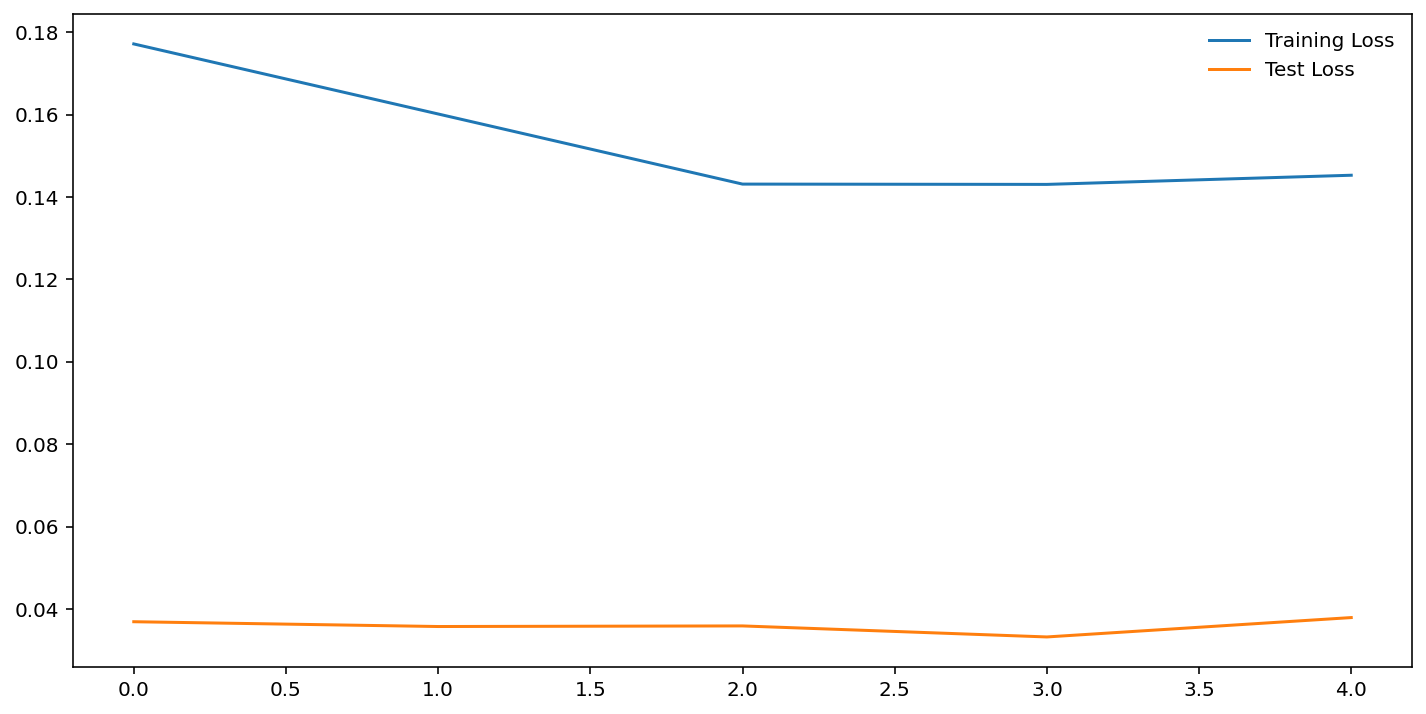

In [81]:
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)
plt.show()

In [103]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.2)
    ax2.set_yticks(np.arange(2))
    ax2.set_ylabels(['Cats','Dogs'],size='small');
    ax2.set_title("Class probabilities")
    ax2.set_xlim(0,1.1)
    
    plt.titght_layout()

In [105]:
model.eval()

dataiter = iter(testloader)
images, label = dataiter.next()
images = images.to(device)
# images.shape

with torch.no_grad():
    output = model.forward(images)

ps = torch.exp(output)
print(ps)
# view_classify(images, ps)

tensor([[1.0000e+00, 4.6318e-06],
        [9.9315e-01, 6.8509e-03],
        [1.0000e+00, 5.5007e-08],
        [1.0000e+00, 1.0530e-07],
        [1.0000e+00, 1.7527e-07],
        [1.0000e+00, 2.4965e-06],
        [1.0000e+00, 2.0197e-08],
        [1.0000e+00, 4.8527e-08],
        [1.0000e+00, 1.0558e-08],
        [1.0000e+00, 5.6294e-07],
        [9.9976e-01, 2.3556e-04],
        [9.9968e-01, 3.1896e-04],
        [9.9928e-01, 7.2021e-04],
        [9.9992e-01, 7.9101e-05],
        [1.0000e+00, 5.8544e-10],
        [1.0000e+00, 1.6018e-07],
        [1.0000e+00, 2.2326e-06],
        [9.8853e-01, 1.1471e-02],
        [1.0000e+00, 5.4412e-07],
        [1.0000e+00, 1.4446e-07],
        [1.0000e+00, 1.1539e-08],
        [1.0000e+00, 4.0676e-07],
        [9.4207e-01, 5.7926e-02],
        [9.9710e-01, 2.9034e-03],
        [9.4918e-01, 5.0817e-02],
        [1.0000e+00, 1.8424e-08],
        [1.0000e+00, 2.7828e-11],
        [9.9999e-01, 1.0030e-05],
        [1.0000e+00, 1.7136e-08],
        [1.000

In [107]:
torch.save(model.state_dict(),'model.pth')

In [108]:
torch.cuda.empty_cache()